In [1]:
NSIMSAMPS = 100_000    # Samples to draw from the simulator
epsilon = 8/7*0.99     # epsilon-greedy behavior policy
runs = list(range(10)) # Repeat for 10 replications

output_dir = '../datagen/{}-100k/'.format('suboptimal99')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_formats = ['svg']

In [4]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [5]:
import numpy as np
import cf.counterfactual as cf
import cf.utils as utils
import pandas as pd
import pickle
import itertools as it
from tqdm import tqdm
import scipy.sparse

# Sepsis Simulator code
from sepsisSimDiabetes.State import State
from sepsisSimDiabetes.Action import Action
from sepsisSimDiabetes.DataGenerator import DataGenerator
import sepsisSimDiabetes.MDP as simulator 

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
import joblib

In [7]:
import pathlib
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

In [8]:
# Max length of each trajectory
NSTEPS = 20

# Probability of diabetic state being set to 1
PROB_DIAB = 0.2

# Number of actions from properties of the simulator
n_actions = Action.NUM_ACTIONS_TOTAL

In [9]:
# Create epsilon-greedy policy
optPol = joblib.load('../data/π_star.joblib')
randomPol = np.ones_like(optPol) / n_actions
behaviorPol = epsilon * randomPol + (1 - epsilon) * optPol

In [10]:
def conv_to_np(this_list):
    this_arr = np.array(this_list)[:, np.newaxis]
    # Make this idempotent
    this_arr = this_arr.squeeze()[:, np.newaxis]
    return this_arr

In [11]:
# Generate batches of data with N episodes each
for it in runs:
    print('Iteration:', it, flush=True)
    np.random.seed(it)
    dgen = DataGenerator()
    states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
       NSIMSAMPS, NSTEPS, policy=behaviorPol[:-2], policy_idx_type='full', output_state_idx_type='full',
       p_diabetes=PROB_DIAB, modified=False, use_tqdm=True) #True, tqdm_desc='Behaviour Policy Simulation')

    obs_samps = utils.format_dgen_samps(
       states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

    df_samp_list = []
    infos = []
    for i in range(NSIMSAMPS):
        pt_id = i + it*NSIMSAMPS
        df_i, (len_i, y_i) = utils.df_from_samps(obs_samps, i, get_outcome=True, is_full=True)
        df_i['pt_id'] = pt_id
        df_i['Diabetic'] = diab[i][:len_i+1]
        df_i['State_idx'] = states[i][:len_i+1]
        df_i['Obs_idx'] = df_i['State_idx'].apply(lambda s: State(state_idx=s, idx_type='full').get_state_idx('obs'))
        df_i['Proj_idx'] = df_i['State_idx'].apply(lambda s: State(state_idx=s, idx_type='full').get_state_idx('proj_obs'))
        df_i['Action'] = actions[i][:len_i+1]
        df_i['Reward'] = 0
        df_i.loc[len_i, 'Reward'] = y_i
        df_i = df_i.set_index('pt_id').reset_index()
        df_samp_list.append(df_i)
        infos.append([pt_id, diab[i][0], y_i, len_i, len(df_i)])

    df_samps = pd.concat(df_samp_list).astype(int)
    df_features = pd.get_dummies(df_samps, columns=['Diabetic', 'Heart Rate', 'SysBP', 'Percent O2', 'Glucose', 'Treat: AbX', 'Treat: Vaso', 'Treat: Vent'])
    df_samps_info = pd.DataFrame(infos, columns=['pt_id', 'Diabetic', 'Outcome', 'Steps', 'Length']).astype(int)
    
    assert df_samps.shape[1] == 15
    assert df_features.shape[1] == 28
    assert df_samps_info.shape[1] == 5
    df_samps.to_csv('{}/{}-samples.csv'.format(output_dir, it), index=False)
    df_features.to_csv('{}/{}-features.csv'.format(output_dir, it), index=False)
    df_samps_info.to_csv('{}/{}-info.csv'.format(output_dir, it), index=False)
    joblib.dump([states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals], '{}/{}-alldata.joblib'.format(output_dir, it))
    joblib.dump(obs_samps, '{}/{}-obs_samps.joblib'.format(output_dir, it))

Iteration: 0


Iteration: 1


Iteration: 2


Iteration: 3


100%|█████████▉| 99989/100000 [03:00<00:00, 540.91it/s]

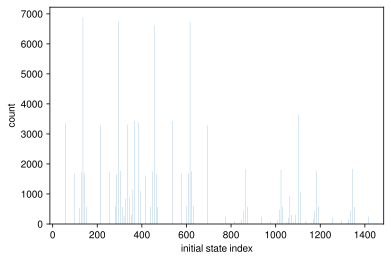

In [12]:
plt.bar(range(1440), df_samps.groupby('pt_id').first()['State_idx'].value_counts().reindex(range(1440)))
plt.xlabel('initial state index')
plt.ylabel('count')
plt.show()

# Features

In [13]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from collections import defaultdict
import pickle
import itertools
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
import joblib
from joblib import Parallel, delayed

In [15]:
import scipy.sparse

## 21-dimensional state features

In [16]:
nS, nA = 1442, 8
d = 21

In [17]:
def get_state_action_feature(x_s, a):
    x_sa = np.zeros((nA, d))
    x_sa[a, :] = x_s
    return x_sa.flatten()

In [18]:
def make_features_single_trajectory(df_i):
    # Initial timestep
    s_init = df_i.iloc[0, 7:28].values
    x_s_init = np.array(s_init)
    xa_s_init_all = np.array([get_state_action_feature(x_s_init, a_) for a_ in range(nA)])

    # Intermediate timestep
    if len(df_i) > 1:
        s = df_i.iloc[:-1, 7:28].values
        a = df_i.iloc[:-1]['Action'].values
        r = df_i.iloc[:-1]['Reward'].values
        s_next = df_i.iloc[1:, 7:28].values

        n = len(s)
        x_s = np.array(s)
        xa_sa = np.array([get_state_action_feature(x_s[j, :], a[j]) for j in range(n)])

        x_s_next = np.array(s_next)
        xa_s_next_all = np.vstack([
            np.vstack([get_state_action_feature(x_s_next[j], a_) for a_ in range(nA)]) 
            for j in range(n)
        ])
    else:
        x_s = np.array((0, d))
        a = np.zeros((0), dtype=int)
        xa_sa = np.array((0, d*nA))
        r = np.zeros((0))
        x_s_next = np.array((0, d))
        xa_s_next_all = np.array((0, d*nA))

    # Final timestep
    s_last = df_i.iloc[-1, 7:28].values
    a_last = df_i.iloc[-1]['Action']
    r_last = df_i.iloc[-1]['Reward']
    if r_last == -1 or r_last == 1:
        # Reached death/disch states
        # every action leads to reward
        x_s_last = np.array(s_last)
        xa_s_last_all = np.array([get_state_action_feature(x_s_last, a_) for a_ in range(nA)])
        r_last_all = np.array(nA * [r_last])

        xa_out = np.vstack([xa_sa, xa_s_last_all])
        xa_next_out = np.vstack([xa_s_next_all, np.zeros((nA*nA, nA*d))])
        r_out = np.concatenate([r, r_last_all])

        a_out = np.concatenate([a, (list(range(nA)))])
        x_out = np.vstack([x_s, *(nA*[x_s_last])])
        x_next_out = np.vstack([x_s_next, np.zeros((nA, d))])
    else: 
        # terminated early due to max length, so no next state information
        xa_out = xa_sa
        xa_next_out = xa_s_next_all
        r_out = r

        x_out = x_s
        a_out = a
        x_next_out = x_s_next
    
    return x_s_init, xa_s_init_all, x_out, a_out, xa_out, r_out, x_next_out, xa_next_out

In [19]:
for it in runs:
    df_features = pd.read_csv('{}/{}-features.csv'.format(output_dir, it))
    out = [make_features_single_trajectory(df_i) for i, df_i in tqdm(df_features.groupby('pt_id'))]
    X_init, Xa_init, X, A, Xa, R, X_next, Xa_next = zip(*out)
    X_init = np.vstack(X_init)
    Xa_init = np.vstack(Xa_init)
    X = np.vstack(X)
    Xa = np.vstack(Xa)
    A = np.concatenate(A)
    R = np.concatenate(R)
    X_next = np.vstack(X_next)
    Xa_next = np.vstack(Xa_next)
    print(Xa_init.shape, Xa.shape, Xa_next.shape, R.shape)
    print(X_init.shape, X.shape, A.shape, R.shape, X_next.shape)

    # Store indices of beginning of each episode
    lengths = [len(x_i) for x_i in list(zip(*out))[2]]
    inds_init = np.cumsum([0] + lengths)

    joblib.dump({
        'X_init': X_init, 'X': X, 'A': A, 'R': R, 'X_next': X_next, 
        'Xa_init': Xa_init, 'Xa': Xa, 'Xa_next': Xa_next,
        'lengths': lengths, 'inds_init': inds_init,
    }, '{}/{}-21d-feature-matrices.joblib'.format(output_dir, it))

    joblib.dump({
        'X_init': scipy.sparse.csr_matrix(X_init), 'X': scipy.sparse.csr_matrix(X), 'A': A, 'R': R, 'X_next': scipy.sparse.csr_matrix(X_next), 
        'Xa_init': scipy.sparse.csr_matrix(Xa_init), 'Xa': scipy.sparse.csr_matrix(Xa), 'Xa_next': scipy.sparse.csr_matrix(Xa_next),
        'lengths': lengths, 'inds_init': inds_init,
    }, '{}/{}-21d-feature-matrices.sparse.joblib'.format(output_dir, it))

100%|██████████| 100000/100000 [03:02<00:00, 548.19it/s]


(800000, 168) (1505769, 168) (12046152, 168) (1505769,)
(100000, 21) (1505769, 21) (1505769,) (1505769,) (1505769, 21)


100%|██████████| 100000/100000 [03:03<00:00, 544.13it/s]


(800000, 168) (1506841, 168) (12054728, 168) (1506841,)
(100000, 21) (1506841, 21) (1506841,) (1506841,) (1506841, 21)


100%|██████████| 100000/100000 [02:58<00:00, 560.25it/s]


(800000, 168) (1508303, 168) (12066424, 168) (1508303,)
(100000, 21) (1508303, 21) (1508303,) (1508303,) (1508303, 21)


100%|██████████| 100000/100000 [02:54<00:00, 574.22it/s]


(800000, 168) (1510211, 168) (12081688, 168) (1510211,)
(100000, 21) (1510211, 21) (1510211,) (1510211,) (1510211, 21)


100%|██████████| 100000/100000 [02:53<00:00, 575.17it/s]


(800000, 168) (1506693, 168) (12053544, 168) (1506693,)
(100000, 21) (1506693, 21) (1506693,) (1506693,) (1506693, 21)


100%|██████████| 100000/100000 [03:00<00:00, 552.94it/s]


(800000, 168) (1502636, 168) (12021088, 168) (1502636,)
(100000, 21) (1502636, 21) (1502636,) (1502636,) (1502636, 21)


 82%|████████▏ | 81890/100000 [02:22<00:31, 580.96it/s]